In [1]:
import os
import sys
import platform
from pandas.plotting import autocorrelation_plot

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm

import scipy.signal as signal
from scipy.fftpack import fft, fftshift

import random
from datetime import datetime, timedelta

In [2]:
def reseed(seed=1863):
    np.random.seed(seed)
    random.seed(seed)

reseed()

In [3]:
%matplotlib inline

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'20'}

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [4]:
# shutdown_id - 1000
# sec_from_start - 500000
columns = ['time_stamp', 'shutdown_id', 'RPM', 'sec_from_start']
data = pd.DataFrame(columns= columns)

In [5]:
def signal_generator(signal_len, is_abnormal=0):
    tau = 400.0

    #noize 
    fs = 10
    noise_power = 0.0005 * fs / 2
    time = np.arange(signal_len) / fs

    gfg = np.random.exponential(50, signal_len)
    x = np.random.exponential(gfg, size = signal_len)

    tau2 = -(signal_len-1) / np.log(0.1)
    window = signal.exponential(signal_len, 0, tau2, False)
    window += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)


    if is_abnormal == 1:

        start = random.randrange(0, signal_len-70)
        step = random.randrange(40, 70)
        end = start + step

        outlier = random.uniform(0.2, 0.35)

        for item in range(start,end):
            window[item] += outlier

    return window

In [6]:
generated = signal_generator(500)

Text(0.5, 0, 'Sample')

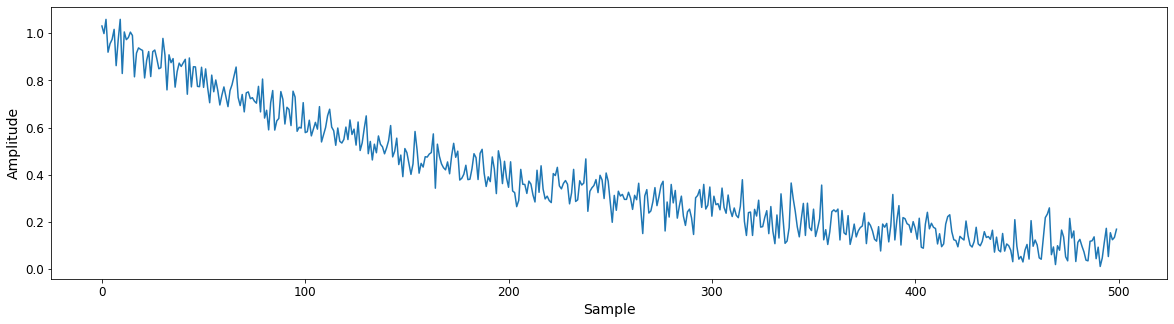

In [7]:
fig = plt.figure()
fig.set_size_inches(20, 5)

plt.plot(generated)
plt.ylabel("Amplitude")
plt.xlabel("Sample")

In [8]:
def random_date(start, end):
    """
    Returns a random datetime between two datetime objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = random.randrange(int_delta)
    return start + timedelta(seconds=random_second)

In [9]:
def date_interval_generator(signal_len):
    time_list = []
    d1 = datetime.strptime('08/09/2020 1:30 PM', '%m/%d/%Y %I:%M %p')
    d2 = datetime.strptime('04/25/2021 4:50 AM', '%m/%d/%Y %I:%M %p')
    start_date = random_date(d1, d2)
    for item in range(signal_len):
        start_date += timedelta(seconds = 1)
        time_list.append(start_date.strftime("%b %d %Y %H:%M:%S"))
    return time_list

In [10]:
def to_data_frame(amount_of_shutdowns=5, signal_len=500, outlier_probability=0.2):
    columns = ['time_stamp', 'shutdown_id', 'RPM', 'sec_from_start', 'is_abnormal']
    data = pd.DataFrame(columns= columns)

    start_date = datetime.strptime('9/08/2020 1:30 PM', '%m/%d/%Y %I:%M %p')
        
    for shutdown in range(amount_of_shutdowns):
        is_abnormal = np.random.choice([0,1] , p = (1 - outlier_probability, outlier_probability))

        time_interval  = date_interval_generator(signal_len)
        shutdown_id = [shutdown] * signal_len
        rpm =  signal_generator(signal_len,is_abnormal)
        secs_from_start = np.arange(signal_len)
        is_abnormal_column = [is_abnormal] * signal_len

        columns_to_values = {'time_stamp': time_interval,
                             'shutdown_id': shutdown_id,
                             'RPM': rpm,
                             'sec_from_start': secs_from_start,
                             'is_abnormal': is_abnormal_column}
        data = data.append(pd.DataFrame(columns_to_values, columns=data.columns))
    return data

In [11]:
df = to_data_frame(amount_of_shutdowns=1000, signal_len=500, outlier_probability = 0.2)

In [12]:
df

time_stamp shutdown_id       RPM sec_from_start is_abnormal
0    Jan 07 2021 13:15:22           0  1.007726              0           0
1    Jan 07 2021 13:15:23           0  0.977986              1           0
2    Jan 07 2021 13:15:24           0  0.867193              2           0
3    Jan 07 2021 13:15:25           0  0.952333              3           0
4    Jan 07 2021 13:15:26           0  0.954875              4           0
..                    ...         ...       ...            ...         ...
495  Dec 27 2020 23:35:25         999  0.052713            495           1
496  Dec 27 2020 23:35:26         999  0.060816            496           1
497  Dec 27 2020 23:35:27         999  0.145114            497           1
498  Dec 27 2020 23:35:28         999  0.144954            498           1
499  Dec 27 2020 23:35:29         999  0.132312            499           1

[500000 rows x 5 columns]

In [13]:
plot_data = df[df['is_abnormal'] == 1]

In [14]:
len(plot_data['shutdown_id'].unique())

192

Text(0.5, 0, 'Sample')

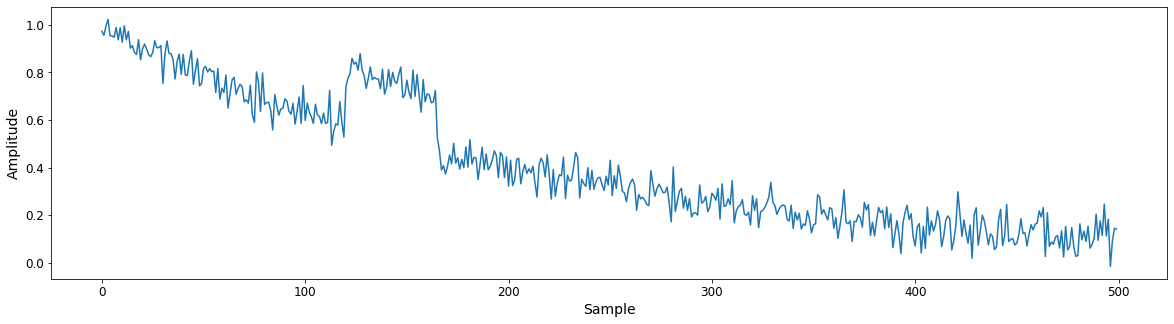

In [15]:
fig = plt.figure()
fig.set_size_inches(20, 5)

plt.plot(plot_data[plot_data['shutdown_id'] == plot_data.shutdown_id.iloc[0]]['RPM'])
plt.ylabel("Amplitude")
plt.xlabel("Sample")

<AxesSubplot:>

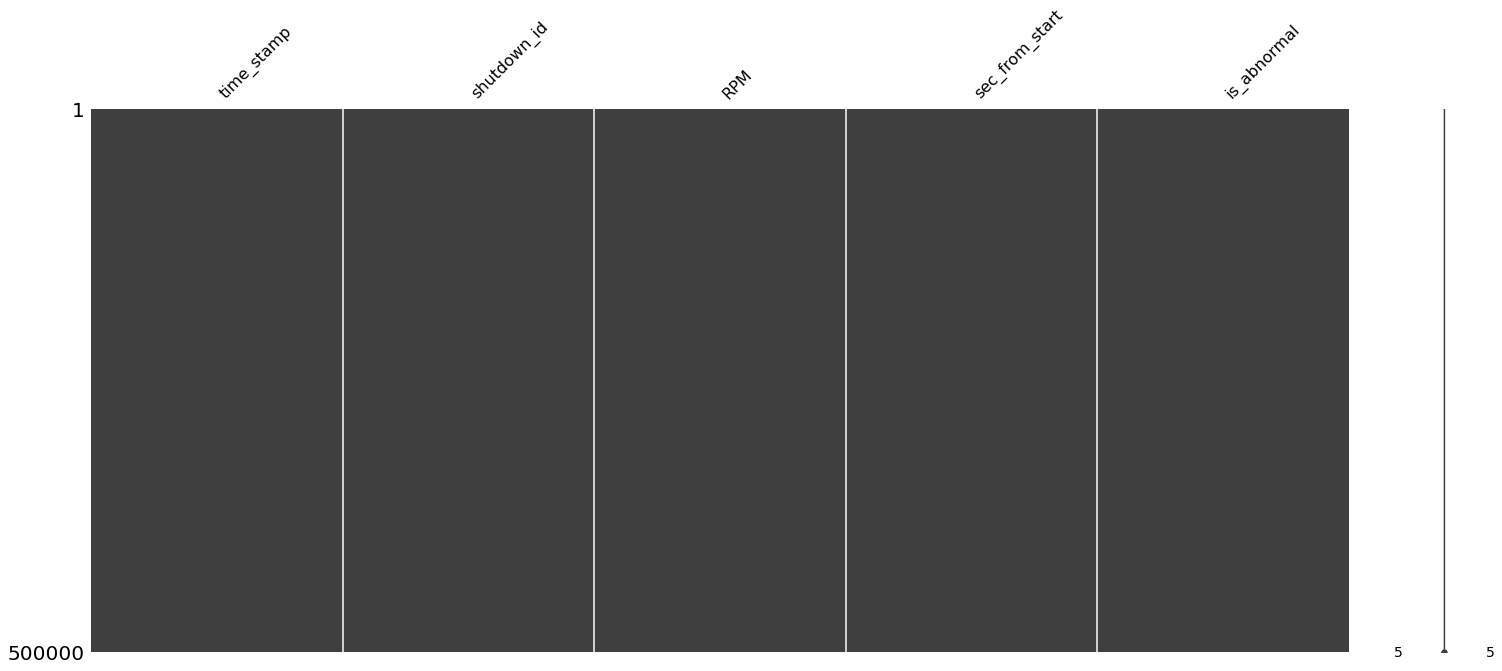

In [16]:
import missingno as msno
msno.matrix(df)

In [17]:
df.to_csv('generated_data.csv', index=False)
df

time_stamp shutdown_id       RPM sec_from_start is_abnormal
0    Jan 07 2021 13:15:22           0  1.007726              0           0
1    Jan 07 2021 13:15:23           0  0.977986              1           0
2    Jan 07 2021 13:15:24           0  0.867193              2           0
3    Jan 07 2021 13:15:25           0  0.952333              3           0
4    Jan 07 2021 13:15:26           0  0.954875              4           0
..                    ...         ...       ...            ...         ...
495  Dec 27 2020 23:35:25         999  0.052713            495           1
496  Dec 27 2020 23:35:26         999  0.060816            496           1
497  Dec 27 2020 23:35:27         999  0.145114            497           1
498  Dec 27 2020 23:35:28         999  0.144954            498           1
499  Dec 27 2020 23:35:29         999  0.132312            499           1

[500000 rows x 5 columns]